# Cross validation is used to show the performance of various methods

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
from array import array
import matplotlib.pyplot as plt

# metric calculation: CC and RMSE
def cal_metric(obs, est):
    ind = ~np.isnan(obs+est)
    obs, est = obs[ind], est[ind]
    if len(obs) > 3:
        cc = np.corrcoef(obs, est)[0,1]
        rmse = np.mean( (obs - est)**2) ** 0.5
    else:
        cc = np.nan
        rmse = np.nan
    return [cc, rmse]



In [2]:
# Load inputs
infile_LWLRstatic = '../../test_cases/cali2017/PyGMET_output/regression_outputs/LWLRstatic_CrossValidation_Regression_20170201-20170215.nc'
infile_LWLRdynamic = '../../test_cases/cali2017/PyGMET_output/regression_outputs/LWLRdynamic_CrossValidation_Regression_20170201-20170215.nc'
infile_LWLRdynami_BoxcoxP = '../../test_cases/cali2017/PyGMET_output/regression_outputs/LWLRdynamic_BoxcoxP_CrossValidation_Regression_20170201-20170215.nc'
infile_RFstatic = '../../test_cases/cali2017/PyGMET_output/regression_outputs/RFstatic_CrossValidation_Regression_20170201-20170215.nc'
infile_RFdynamic = '../../test_cases/cali2017/PyGMET_output/regression_outputs/RFdynamic_CrossValidation_Regression_20170201-20170215.nc'

infile_obs = f'../../test_cases/cali2017/PyGMET_output/stn_info/all_stn.nc'
infile_est = [infile_LWLRstatic, infile_LWLRdynamic, infile_LWLRdynami_BoxcoxP, infile_RFstatic, infile_RFdynamic]
types_est = ['LWLRstatic', 'LWLRdynamic', 'LWLRdynami_BoxcoxP', 'RFstatic', 'RFdynamic']


ds_est = [xr.load_dataset(f) for f in infile_est]
ds_obs = xr.load_dataset(infile_obs)
ds_obs = ds_obs.sel(time=ds_est[0]['time'])

ds_obs['pop'] = ds_obs['prcp'].copy()
v = ds_obs['pop'].values
v[v >= 0.01] = 1
v[v < 0.01] = 0
ds_obs['pop'].values = v

In [3]:
# calculate metrics
varnames = ['prcp_boxcox', 'pop', 'tmean', 'trange']

nv = len(varnames)
nt = len(types_est)
nstn = len(ds_obs.stn)
metrics = np.zeros([nv, nt, nstn, 2])

for i in range(nv):
    obs = ds_obs[varnames[i]].values
    for j in range(nt):
        est = ds_est[j][varnames[i]].values
        for q in range(nstn):
            metrics[i, j, q, :] = cal_metric(obs[q, :], est[q, :])


/opt/anaconda3/envs/general/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/envs/general/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [4]:
# statistics
metrics_mean = np.nanmean(metrics, axis=2)
df_cc = pd.DataFrame(metrics_mean[:,:,0], index=varnames, columns=types_est)
print('Correlation coefficient')
print(df_cc)

df_rmse = pd.DataFrame(metrics_mean[:,:,1], index=varnames, columns=types_est)
print('\nRMSE')
print(df_rmse)

Correlation coefficient
             LWLRstatic  LWLRdynamic  LWLRdynami_BoxcoxP  RFstatic  RFdynamic
prcp_boxcox    0.839374     0.826336            0.825445  0.835825   0.830575
pop            0.742654     0.718198            0.715097  0.775006   0.773498
tmean          0.842924     0.830778            0.832510  0.826356   0.817864
trange         0.813773     0.795061            0.794719  0.805326   0.803412

RMSE
             LWLRstatic  LWLRdynamic  LWLRdynami_BoxcoxP  RFstatic  RFdynamic
prcp_boxcox    1.725545     1.793942            1.796914  1.754395   1.767151
pop            0.299377     0.315809            0.317152  0.282062   0.284138
tmean          1.524449     1.574112            1.557716  1.569041   1.587475
trange         2.709377     2.812867            2.806892  2.761664   2.751890


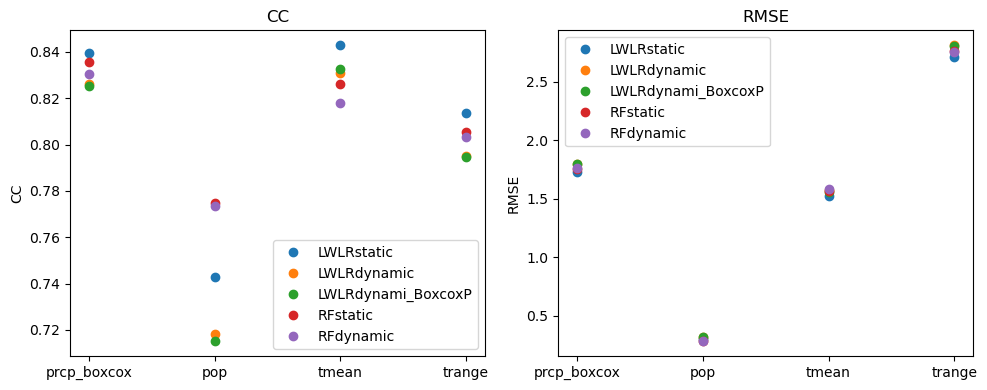

In [5]:
# simple plots
fig, axs = plt.subplots(1, 2, figsize=[10, 4])

labs = ['CC', 'RMSE']

for i in range(2):
    axi = axs[i]
    axi.plot(varnames, metrics_mean[:,:,i], 'o')
    axi.set_ylabel(labs[i])
    axi.set_title(labs[i])
    axi.legend(types_est)
    
    # axi.plot(types_est, metrics_mean[:,:,i].T)
    # axi.set_ylabel(labs[i])
    # axi.set_title(labs[i])
    # axi.legend(varnames)
    

plt.tight_layout()    
plt.show()